# Тестирование библиотеки для матричного разложения с использованием градиентного спуска

## Оглавлние

1. Импорт библиотек
2. Загрузка и обработка данных
3. Тестирование 
    1. Тестирование написанной библиотеки
    2. Сравнение с готовыми решениями
    3. Сравнение с реализацией на Python (Время работы)

## Импорт библиотек

In [1]:
# Функция для равномерного распределения
from random import uniform

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Метрика nBCG@k
from sklearn.metrics import ndcg_score

# Библиотека с реализацией разложения 
import SVD4Rec

# Готовое решение
from surprise import SVD
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
from surprise import Dataset, Reader

## Загрузка и обработка данных

In [2]:
film_rating = pd.read_csv('data/ml-latest-small/ratings.csv')
film_rating.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [3]:
film_rating['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [4]:
film_rating = film_rating.drop('timestamp', axis=1)

In [5]:
n_users = film_rating['userId'].unique().shape[0]
n_items = film_rating['movieId'].unique().shape[0]
print(f'Количество фильмов - {n_items}, количество пользователей - {n_users}')

Количество фильмов - 9724, количество пользователей - 610


In [6]:
film_rating = film_rating.pivot(index='userId', columns='movieId', values='rating')

In [7]:
nan_film_rating = round(film_rating.isna().sum().sum() / film_rating.shape[0] / film_rating.shape[1] * 100, 3)
print(f'Процент пустых значений: {nan_film_rating}%')

Процент пустых значений: 98.3%


## Тестирование

### Тестирование написанной библиотеки

Получим векторные представления пользователей $P$ и векторные представления товаров $Q$ на основе матрицы рейтингов.

Тогда наша исходная матрица аппроксимируется следующим образом: $$ R_{n \times m} \approx P_{n \times k} \times Q_{k \times m}^T$$

$n$, $m$, $k$ - количество пользователей, количество товаров, размерность вектора представления товара и пользователя (гиперпараметр) соответственно.

#### MSE

Для начала посчитаем $MSE$ на всех данных.

Так как мы решаем задачу невыпуклой оптимизации с помощью стохастического градиентного спуска, то каждый раз мы будем получаеть разные локальные минимумы. Имеет смысл провести несколько запусков и усреднить значение $MSE$.

In [8]:
R = film_rating.to_numpy()

In [9]:
MSE = 0
P, Q = SVD4Rec.LFM_SGD(R)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        if not np.isnan(R[i, j]):
            MSE += (R[i, j] - P[i] @ Q[j]) ** 2

MSE = 1 / film_rating.notna().sum().sum() * MSE

print(f'Mean MSE = {MSE}', f'Mean RMSE = {np.sqrt(MSE)}', sep='\n')

Mean MSE = 2.0966897992637246
Mean RMSE = 1.4479950964225412


Получаем $MSE = 1.5339$ и $RMSE = 1.2385$, что является неплохим показателем.

Посчитаем $MSE$ на тестовых данных для этогого разложим нашу матрицу на две (на $train$ и на $test$ в отношении $0.1$).

In [10]:
def train_test_split(R, test_size=.1):
    R_train = R.copy()
    test = []
    for i in range(R_train.shape[0]):
        for j in range(R_train.shape[1]):
            if not np.isnan(R_train[i, j]) and uniform(0, 1) < test_size:
                test.append((i, j))
                R_train[i, j] = np.nan
    return R_train, test

In [11]:
R_train, test = train_test_split(R)
MSE = 0
P, Q = SVD4Rec.LFM_SGD(R_train)
for i, j in test:
    MSE += (R[i, j] - P[i] @ Q[j]) ** 2
MSE = 1 / len(test) * MSE

print(f'MSE = {MSE}', f'RMSE = {np.sqrt(MSE)}', sep='\n')

MSE = 3.5527440509833292
RMSE = 1.8848724229993206


Получили качество $MSE = 3.0816$ и $RMSE = 1.7555$.

Можно продолжить улучшение наших метрик добавлением валидационной выборки $valid$, являющейся частью $test$ выборки. Валидационную выборку имеет смысл использовать, чтобы не измерять качество на тестовой и не переобучаться под неё, так как подразумевается, что значения тестовой выборки мы не знаем. А также валидационная выборка позволит найти лучшее значение гипперпараметра $k$.

*Можно продолжить и дальше - применить кросс-валидацию, но остановимся лишь на добавлении валидационной выборки.*

In [12]:
def make_valid_sample(R, test_size=.1, valid_size=.5):
    R_train, test = train_test_split(R, test_size)
    valid = test[int(valid_size*len(test)):]
    test =  test[:int(valid_size*len(test))]
    return R_train, valid, test

In [13]:
R_train, valid, test = make_valid_sample(R)
best_P_Q = None
best_MSE = np.inf

In [14]:
for num_iter in [250]: # range(10, 250, 10):
    for k in [1]: #range(1, 20):
        MSE = 0
        P, Q = SVD4Rec.LFM_SGD(R_train, num_iter=num_iter, k=k)
        for i, j in valid:
            MSE += (R[i, j] - P[i] @ Q[j]) ** 2
        MSE = 1 / len(test) * MSE
        if MSE < best_MSE:
            best_P_Q = (P, Q)
            best_MSE = MSE

MSE = 0
P, Q = best_P_Q
for i, j in test:
    MSE += (R[i, j] - P[i] @ Q[j]) ** 2
MSE = 1 / len(test) * MSE

print(f'MSE = {MSE}', f'RMSE = {np.sqrt(MSE)}', f'best k = {P.shape[1]}', sep='\n')

MSE = 1.0500109680341019
RMSE = 1.024700428434624
best k = 1


Получили $MSE = 1.1648$ и $RMSE = 1.0793$. 

*Для рассчета дальнейших метрик будем брать лучшее разложение.*

#### precision@k

$$ precision@k(q) = \frac{1}{k} \sum_{i=1}^k [y_{(i)} = 1] \ , \qquad precision@k(q) \rightarrow 1$$

Доля реливантных товаров среди $k$ первых. $q$ - конкретные запрос, в данном случае это пользователь. $y_{(i)}$ - предсказание для товара на $i$ позиции для отсортированного списка документов. $[y_{(i)} = 1]$ - индикаторная функция.

#### AP@k

$$ AP@k(q) = \frac{1}{\sum_{i=1}^k y_{(i)}} \sum_{i=1}^k y_{(i)} \cdot precision@i(q)\ , \qquad AP@k(q) \rightarrow 1$$

В отличие от precision@k учитывает порядок.

#### DCG@k

$$ DCG@k(q) = \sum_{k=1}^i g(y_{(i)}) \cdot d(i)\ , \qquad  DCG@k(q) \rightarrow \max$$ 
$$ \text{Обычно:} \qquad g(y) = 2^y \quad \text{и} \quad d(i) = \frac{1}{\log_{2}(i + 1)}$$

В отличие от двух метрик выше, работают не с бинарной классификацией. Она нам подходит, только она не интерпритируема. Её нужно нормализовать, к примеру, поделить на $\max$.

#### nDCG@k

$$ nDCG@k(q) = \frac{DCG@k(q)}{\max DCG@k(q)} \ , \qquad nDCG@k(q) \rightarrow 1$$

Теперь метрика стала интерпритируема. Её и будем использовать.

Есть более хитрые каскадные метрики, но они избыточны для данной задачи.

Выберем пользователей, которые оцениили больше $200$ фильмов. 

In [15]:
R = pd.DataFrame(R)
actual_rating = R.loc[R.T.sum() > 200, :].index.to_list()
for i, j in test:
    if i in actual_rating:
        if type(actual_rating[i]) != list:
            actual_rating[i] = []
        actual_rating[i].append((i, j, R.T[i][j]))

test_ratings = []
for i in range(len(actual_rating)):
    if type(actual_rating[i]) == list and len(actual_rating[i]) > 5:
        test_ratings.append(actual_rating[i])
r = (P @ Q.T)

predict_ratings = []
for i in range(len(test_ratings)):
    tmp = []
    for j in range(len(test_ratings[i])):
        tmp.append((test_ratings[i][j][0], test_ratings[i][j][1], r[test_ratings[i][j][0]][test_ratings[i][j][1]]))
    predict_ratings.append(tmp)

test_ratings = [[test_ratings[i][j][2] for j in range(len(test_ratings[i]))] for i in range(len(test_ratings))]
predict_ratings = [[predict_ratings[i][j][2] for j in range(len(predict_ratings[i]))] for i in range(len(predict_ratings))]

In [16]:
mean = 0
for i in range(len(test_ratings)):
    mean += len(test_ratings[i])

print(f'Среднее количество оставленных оценок пользователем (в тестовых данных): {round(mean / len(test_ratings))}')

Среднее количество оставленных оценок пользователем (в тестовых данных): 26


In [17]:
k = list(range(1, 35))
mean_nbsg = [sum(ndcg_score([test_ratings[i]], [predict_ratings[i]], k=k)/len(test_ratings) 
                for i in range(len(test_ratings))) for k in k]

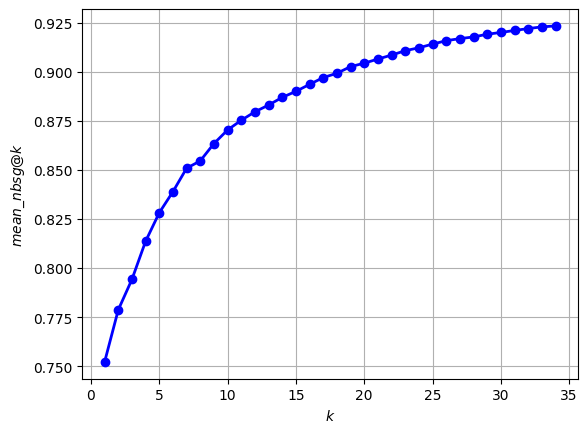

In [18]:
plt.plot(k, mean_nbsg, 'bo-', linewidth=2)
plt.grid()
plt.ylabel('$mean \_ nbsg@k$')
plt.xlabel('$k$')
plt.show()

Для примера, посчитаем $nbsg@30$. 

In [19]:
mean_nbsg[30]

0.9209489473540043

### Сравнение с готовыми решениями

На данный момент есть достаточное количество "коробочных решений" для рекомендательных систем, самые популярные среди них: **Implicit** и **LightFM**. Но мы будем использовать **Surprise**.

Предобработаем данные для того, чтобы использовать **Surprise**.

In [20]:
tmp = pd.DataFrame(R_train).reset_index()
tmp = pd.melt(tmp, id_vars='index').reset_index()\
    .reindex(columns=['index', 'variable', 'value'])\
    .rename({'index': 'user_id', 'variable': 'film_id', 'value': 'rating'}, axis=1)\
    .dropna()\
    .reset_index(drop=True)

tmp['film_id'] = tmp['film_id'].astype('int')
tmp['user_id'] = tmp['user_id'].astype('int')

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(tmp[['user_id', 'film_id', 'rating']], reader=reader)


Подберем гипперпараметры с помощью кросс-валидации

In [21]:
params= {
    'n_factors': [100], # [1, 2, 5, 10, 20, 25, 50, 75, 100],
    "n_epochs": [200], # [5, 10, 25, 50, 100, 150, 200], 
    "lr_all": [.005], # [0.002, 0.005, 0.0025, 0.01, 0.0035], 
    "reg_all": [.1] # [0.4, 0.6, 0.2, 0.1, 0.5]
    }

In [22]:
best_model = RandomizedSearchCV(SVD,
                                param_distributions=params,
                                measures=['rmse', 'mse'],
                                cv=5,
                                n_jobs=-1,
                                n_iter=1, # 300
                                refit=True
            )

In [23]:
best_model.fit(data)

In [24]:
best_model.best_score

{'rmse': 0.8552843662633872, 'mse': 0.7315419233623907}

Получили $RMSE = 0.8551$ и $MSE = 0.7313$.

Лучшие гипперпараметры:

In [25]:
best_model.best_params

{'rmse': {'n_factors': 100, 'n_epochs': 200, 'lr_all': 0.005, 'reg_all': 0.1},
 'mse': {'n_factors': 100, 'n_epochs': 200, 'lr_all': 0.005, 'reg_all': 0.1}}

In [26]:
R = pd.DataFrame(R)
actual_rating = R.loc[R.T.sum() > 200, :].index.to_list()
for i, j in test:
    if i in actual_rating:
        if type(actual_rating[i]) != list:
            actual_rating[i] = []
        actual_rating[i].append((i, j, R.T[i][j]))

test_ratings = []
for i in range(len(actual_rating)):
    if type(actual_rating[i]) == list and len(actual_rating[i]) > 5:
        test_ratings.append(actual_rating[i])

predict_ratings = []
for i in range(len(test_ratings)):
    tmp = []
    for j in range(len(test_ratings[i])):
        tmp.append((test_ratings[i][j][0], test_ratings[i][j][1], best_model.predict(i, j)[3]))
    predict_ratings.append(tmp)

test_ratings = [[test_ratings[i][j][2] for j in range(len(test_ratings[i]))] for i in range(len(test_ratings))]
predict_ratings = [[predict_ratings[i][j][2] for j in range(len(predict_ratings[i]))] for i in range(len(predict_ratings))]

In [27]:
k = list(range(1, 35))
mean_nbsg_a = [sum(ndcg_score([test_ratings[i]], [predict_ratings[i]], k=k)/len(test_ratings) 
                for i in range(len(test_ratings))) for k in k]

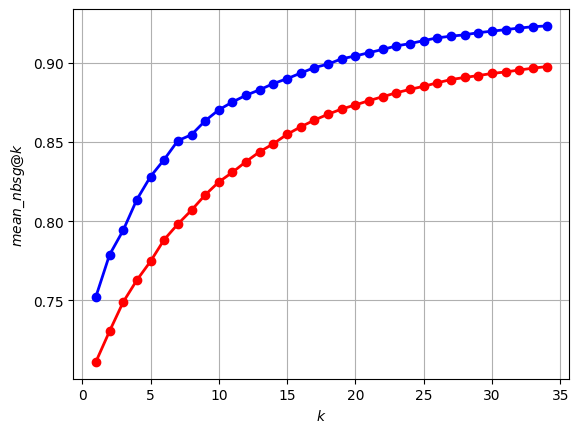

In [28]:
plt.plot(k, mean_nbsg, 'bo-', linewidth=2)
plt.plot(k, mean_nbsg_a, 'ro-', linewidth=2)
plt.grid()
plt.ylabel('$mean \_ nbsg@k$')
plt.xlabel('$k$')
plt.show()

### Сравнение с реализацией на Python (время работы)

Для сравнения возьмем лишь часть данных $R_{1000 \times 1000}$.

In [29]:
def LFM_SGD(R, eps=0.01, num_iter=5000, k=5, lr=0.0003, reg=0.5, batch_size=50):
    num_users, num_items = R.shape

    P = np.random.uniform(0, 5, size=(num_users, k))
    Q = np.random.uniform(0, 5, size=(num_items, k))

    def scal_prod(P, Q):
        return np.dot(P, Q.T)

    for iter in range(num_iter):
        loss = 0
        for batch in range(num_users // batch_size):
            user_indices = np.arange(batch * batch_size, min((batch + 1) * batch_size, num_users))
            np.random.shuffle(user_indices)

            batch_P = P[user_indices]
            batch_R = R[user_indices]

            err = batch_R - np.dot(batch_P, Q.T)

            P[user_indices] += lr * (2 * np.dot(err, Q) - reg * batch_P)
            Q += lr * (2 * np.dot(err.T, batch_P) - reg * Q)

            loss += np.sum(err**2)

        loss /= (num_users * num_items)
        if loss < eps:
            break

    return P, Q

In [30]:
R = pd.DataFrame(R).iloc[:1000, :1000].to_numpy()

In [31]:
%%time
P, Q = SVD4Rec.LFM_SGD(R)

CPU times: user 2.97 s, sys: 29.2 ms, total: 3 s
Wall time: 3.13 s


In [32]:
%%time
P, Q = LFM_SGD(R)

CPU times: user 41.6 s, sys: 54.1 ms, total: 41.7 s
Wall time: 42.1 s


Время работы функции на **C++** $3.56$ секунд, тогда как на **Python** $54.3$.